## Anomaly Detection

* Binary classification problem with a severe class imbalance (fewer anomalies than normal data)
* Commonly used in real-world applications e.g. to detect machine-failures, network-intrusions, or fraud
* Usually treated as an unsupervised task 
* Conventional inductive bias: anomalies are located in areas of the feature space with low density
* E.g. Half-Space Trees uses number of samples in each leaf as an anomaly metric

### Example for Online Anomaly Detection Task: 
Detecting fraudulent credit card transactions using Half-Space Trees

In [1]:
from river import compose, datasets, preprocessing, anomaly
from utils import get_detection_report, seed_everything, StreamTracker
from tqdm import tqdm

seed_everything(42)

# Load dataset with credit card transactions
n_samples = 10_000
data = list(datasets.CreditCard().take(n_samples))

# Create anomaly detection pipeline
model = compose.Pipeline(
    preprocessing.MinMaxScaler(),
    anomaly.QuantileFilter(anomaly.HalfSpaceTrees(seed=42), q=0.99),
)
thresholder = model['QuantileFilter']
model

Pipeline (
  MinMaxScaler (),
  QuantileFilter (
    anomaly_detector=HalfSpaceTrees (
      n_trees=10
      height=8
      window_size=250
      limits=defaultdict(..., {})
      seed=42
    )
    q=0.99
    protect_anomaly_detector=True
  )
)

In [2]:
tracker = StreamTracker()

# Perform test-then-train evaluation
for x, y in tqdm(data):
    # Predict and train on current instance
    score = model.score_one(x)
    model.learn_one(x)

    # Apply thresholding to anomaly score to obtain class predictions
    pred = thresholder.classify(score)

    # Record results
    tracker.update(y, pred, score, thresholder.quantile.get())

# Print results
labels, preds_hs, scores_hs, thresholds_hs = tracker.get()
print(get_detection_report(labels, preds_hs))

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:01<00:00, 5071.68it/s]

Metric          Score     
-----------------------
Precision       20.00%    
Recall          26.32%    
F1              22.73%    
Support         38        


### Deep Anomaly Detection
* Uses similar metrics as conventional methods
* Difference: metrics are calculated after applying a learned non-linear transformation
* E.g. autoencoder calculates anomaly score as distance/error between input and reconstruction 

### Function Scheme of Anomaly Detection with Autoencoders: 
![Autoencoder Anomaly Detection](../resources/ae_ad_schematic.png)

Anomaly detection with autoencoder:

In [3]:
# Import PyTorch and deep-rive modules
import torch
from torch import nn
from deep_river.anomaly import Autoencoder

# Define PyTorch module 
# TODO: turn into blank text?
class MyAutoencoder(nn.Module):
    def __init__(self, n_features, latent_dim=64):
        super().__init__()
        self.encoder = nn.Linear(n_features, latent_dim) 
        self.decoder = nn.Linear(latent_dim, n_features)

    def forward(self, X, **kwargs):
        z = torch.relu(self.encoder(X))
        return torch.sigmoid(self.decoder(z))

# Create anomaly detection pipeline
model = compose.Pipeline(
    preprocessing.MinMaxScaler(),
    anomaly.QuantileFilter(Autoencoder(module=MyAutoencoder, lr=0.25), q=0.99),
)
thresholder = model['QuantileFilter']

tracker = StreamTracker()

for x, y in tqdm(data):
    score = model.score_one(x)
    model.learn_one(x)
    pred = thresholder.classify(score)
    
    tracker.update(pred, score, thresholder.quantile.get())

# Print results
preds_ae, scores_ae, thresholds_ae = tracker.get()
print(get_detection_report(labels, preds_ae))

  1%|          | 110/10000 [00:00<00:09, 1098.49it/s]

100%|██████████| 10000/10000 [00:04<00:00, 2072.26it/s]


Metric          Score     
-----------------------
Precision       34.15%    
Recall          73.68%    
F1              46.67%    
Support         38        


&rarr; Autoencoder yields much better performance, although at higher computational cost. 

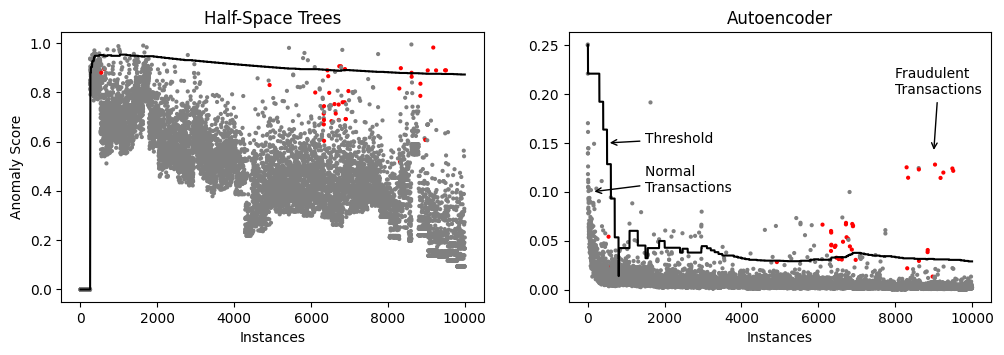

In [19]:
# Visualize anomaly scores of anomaly detectors
import matplotlib.pyplot as plt
import numpy as np

labels = np.array(labels)

fig, axs = plt.subplots(ncols=2, sharex=True, figsize=(12, 3.5))
xs = np.arange(len(scores_ae))
for ax, scores, thresholds in zip(
    axs, [scores_hs, scores_ae], [thresholds_hs, thresholds_ae]
):
    ax.scatter(xs, scores, c=np.where(labels==1, 'red', 'gray'), s=4)
    ax.plot(xs, thresholds, c='black', label='Threshold')
    ax.set_xlabel('Instances')

axs[0].set_ylabel('Anomaly Score')
axs[1].annotate('Fraudulent \nTransactions', xy=[9000, 0.14], xytext=[8000, 0.2], arrowprops={'arrowstyle': "->"})
axs[1].annotate('Normal \nTransactions', xy=[100, 0.1], xytext=[1500, 0.1], arrowprops={'arrowstyle': "->"})
axs[1].annotate('Threshold', xy=[500, 0.15], xytext=[1500, 0.15], arrowprops={'arrowstyle': "->"})
axs[0].set_title('Half-Space Trees')
t = axs[1].set_title('Autoencoder')

In [5]:
# TODO: Content on time series anomaly detection? 


## Time Series Anomaly Detection

* In many real-world data streams distribution of next sample depends on previous samples
* Architecture that considers time dependency are often useful
* 